<a href="https://colab.research.google.com/github/IT22312976/25-26j--340/blob/main/over_take_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Install and Import Libraries
!pip install ultralytics

import os
import yaml
from ultralytics import YOLO
from IPython.display import Image, display
import matplotlib.pyplot as plt
import shutil

print("Libraries installed and imported successfully.")

Libraries installed and imported successfully.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Cell 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 3: Configuration Setup Function
def setup_dataset_config(base_drive_path):
    """
    Creates a temporary data.yaml with absolute paths to avoid path errors.
    """
    # Define your paths based on the structure you provided
    train_path = os.path.join(base_drive_path, 'train/images')
    val_path = os.path.join(base_drive_path, 'valid/images')
    test_path = os.path.join(base_drive_path, 'test/images')

    # Define the dictionary for the YAML file
    data_config = {
        'path': base_drive_path, # Root dir
        'train': train_path,
        'val': val_path,
        'test': test_path,
        'nc': 6,
        'names': ['divider-line', 'dotted-line', 'double-line', 'random-line', 'road-sign-line', 'solid-line']
    }

    # Save this as a new yaml file in the current working directory of Colab
    yaml_path = '/content/custom_data.yaml'
    with open(yaml_path, 'w') as f:
        yaml.dump(data_config, f)

    print(f"Configuration created at: {yaml_path}")
    print(f"Training on classes: {data_config['names']}")
    return yaml_path

In [ ]:
# Cell 4: Training Function
def train_yolo_model(config_path, epochs=25, img_size=640):
    """
    Trains the YOLOv8 model using the provided config.
    """
    # Load a pre-trained YOLOv8n model (nano version is fastest)
    model = YOLO('yolov8n.pt')

    print("Starting training...")
    # Train the model
    # project='runs' and name='train_road_objects' saves results to /content/runs/detect/train_road_objects
    results = model.train(
        data=config_path,
        epochs=epochs,
        imgsz=img_size,
        plots=True,
        project='runs/detect',
        name='train_road_objects',
        exist_ok=True # Overwrite if exists
    )
    print("Training completed.")
    return model

In [ ]:
# Cell 5: Evaluation Display Function
def display_evaluation_metrics(run_folder):
    """
    Displays the graphs generated by YOLOv8 during training.
    """
    print(f"--- Displaying Results from {run_folder} ---")

    # List of key result images to display
    images_to_show = [
        'results.png',          # Loss and accuracy curves
        'confusion_matrix.png', # Confusion Matrix
        'F1_curve.png',         # F1 Score
        'PR_curve.png'          # Precision-Recall Curve
    ]

    for img_name in images_to_show:
        img_path = os.path.join(run_folder, img_name)
        if os.path.exists(img_path):
            print(f"\nDisplaying {img_name}:")
            display(Image(filename=img_path, width=800))
        else:
            print(f"Could not find {img_name} (might not be generated yet).")

In [ ]:
# Cell 6: Prediction & Inference Function
import glob
import random

def load_and_predict(model_path, test_images_dir):
    """
    Loads the trained model and predicts on a random image from the test folder.
    """
    # Load the custom trained model
    # best.pt contains the weights with the highest accuracy during training
    custom_model = YOLO(model_path)

    # Get a list of images from the test directory
    test_images = glob.glob(os.path.join(test_images_dir, '*.jpg')) + \
                  glob.glob(os.path.join(test_images_dir, '*.png'))

    if not test_images:
        print("No images found in test directory.")
        return

    # Pick a random image
    random_image = random.choice(test_images)
    print(f"Predicting on: {random_image}")

    # Run prediction
    results = custom_model.predict(source=random_image, conf=0.25)

    # Show results
    for result in results:
        # Plot the result (draws bounding boxes)
        res_plotted = result.plot()
        # Convert RGB for matplotlib display
        plt.figure(figsize=(10, 10))
        plt.imshow(res_plotted[..., ::-1])
        plt.axis('off')
        plt.show()

In [ ]:
def save_model_to_drive(run_folder, drive_folder, new_name='my_yolo_model.pt'):
    """
    Copies the best model from the Colab runtime to Google Drive.

    Args:
        run_folder (str): Path to the YOLO experiment (e.g., 'runs/detect/train_road_objects')
        drive_folder (str): Path to your Google Drive folder
        new_name (str): What you want to name the file on Drive
    """
    # 1. Construct the path to the best weights automatically saved by YOLO
    source_path = os.path.join(run_folder, 'weights', 'best.pt')

    # 2. Construct the destination path
    destination_path = os.path.join(drive_folder, new_name)

    # 3. Copy the file
    if os.path.exists(source_path):
        # Create the destination folder if it doesn't exist
        os.makedirs(drive_folder, exist_ok=True)

        shutil.copy(source_path, destination_path)
        print(f"✅ Success! Model saved to Google Drive at:\n{destination_path}")
    else:
        print(f"❌ Error: Could not find model at {source_path}")
        print("Check if the training completed successfully.")

In [ ]:
# Execute the setup
# NOTE: This path matches the folder name you provided
DRIVE_FOLDER = '/content/drive/MyDrive/data_sandeepa_wrong_overtake/data'
yaml_config_path = setup_dataset_config(DRIVE_FOLDER)

Configuration created at: /content/custom_data.yaml
Training on classes: ['divider-line', 'dotted-line', 'double-line', 'random-line', 'road-sign-line', 'solid-line']


In [ ]:
# Run the training
# You can increase epochs if accuracy is low
trained_model = train_yolo_model(yaml_config_path, epochs=10)

Starting training...
Ultralytics 8.3.248 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/custom_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_road_objects, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, persp

--- Displaying Results from /content/runs/detect/train_road_objects ---

Displaying results.png:


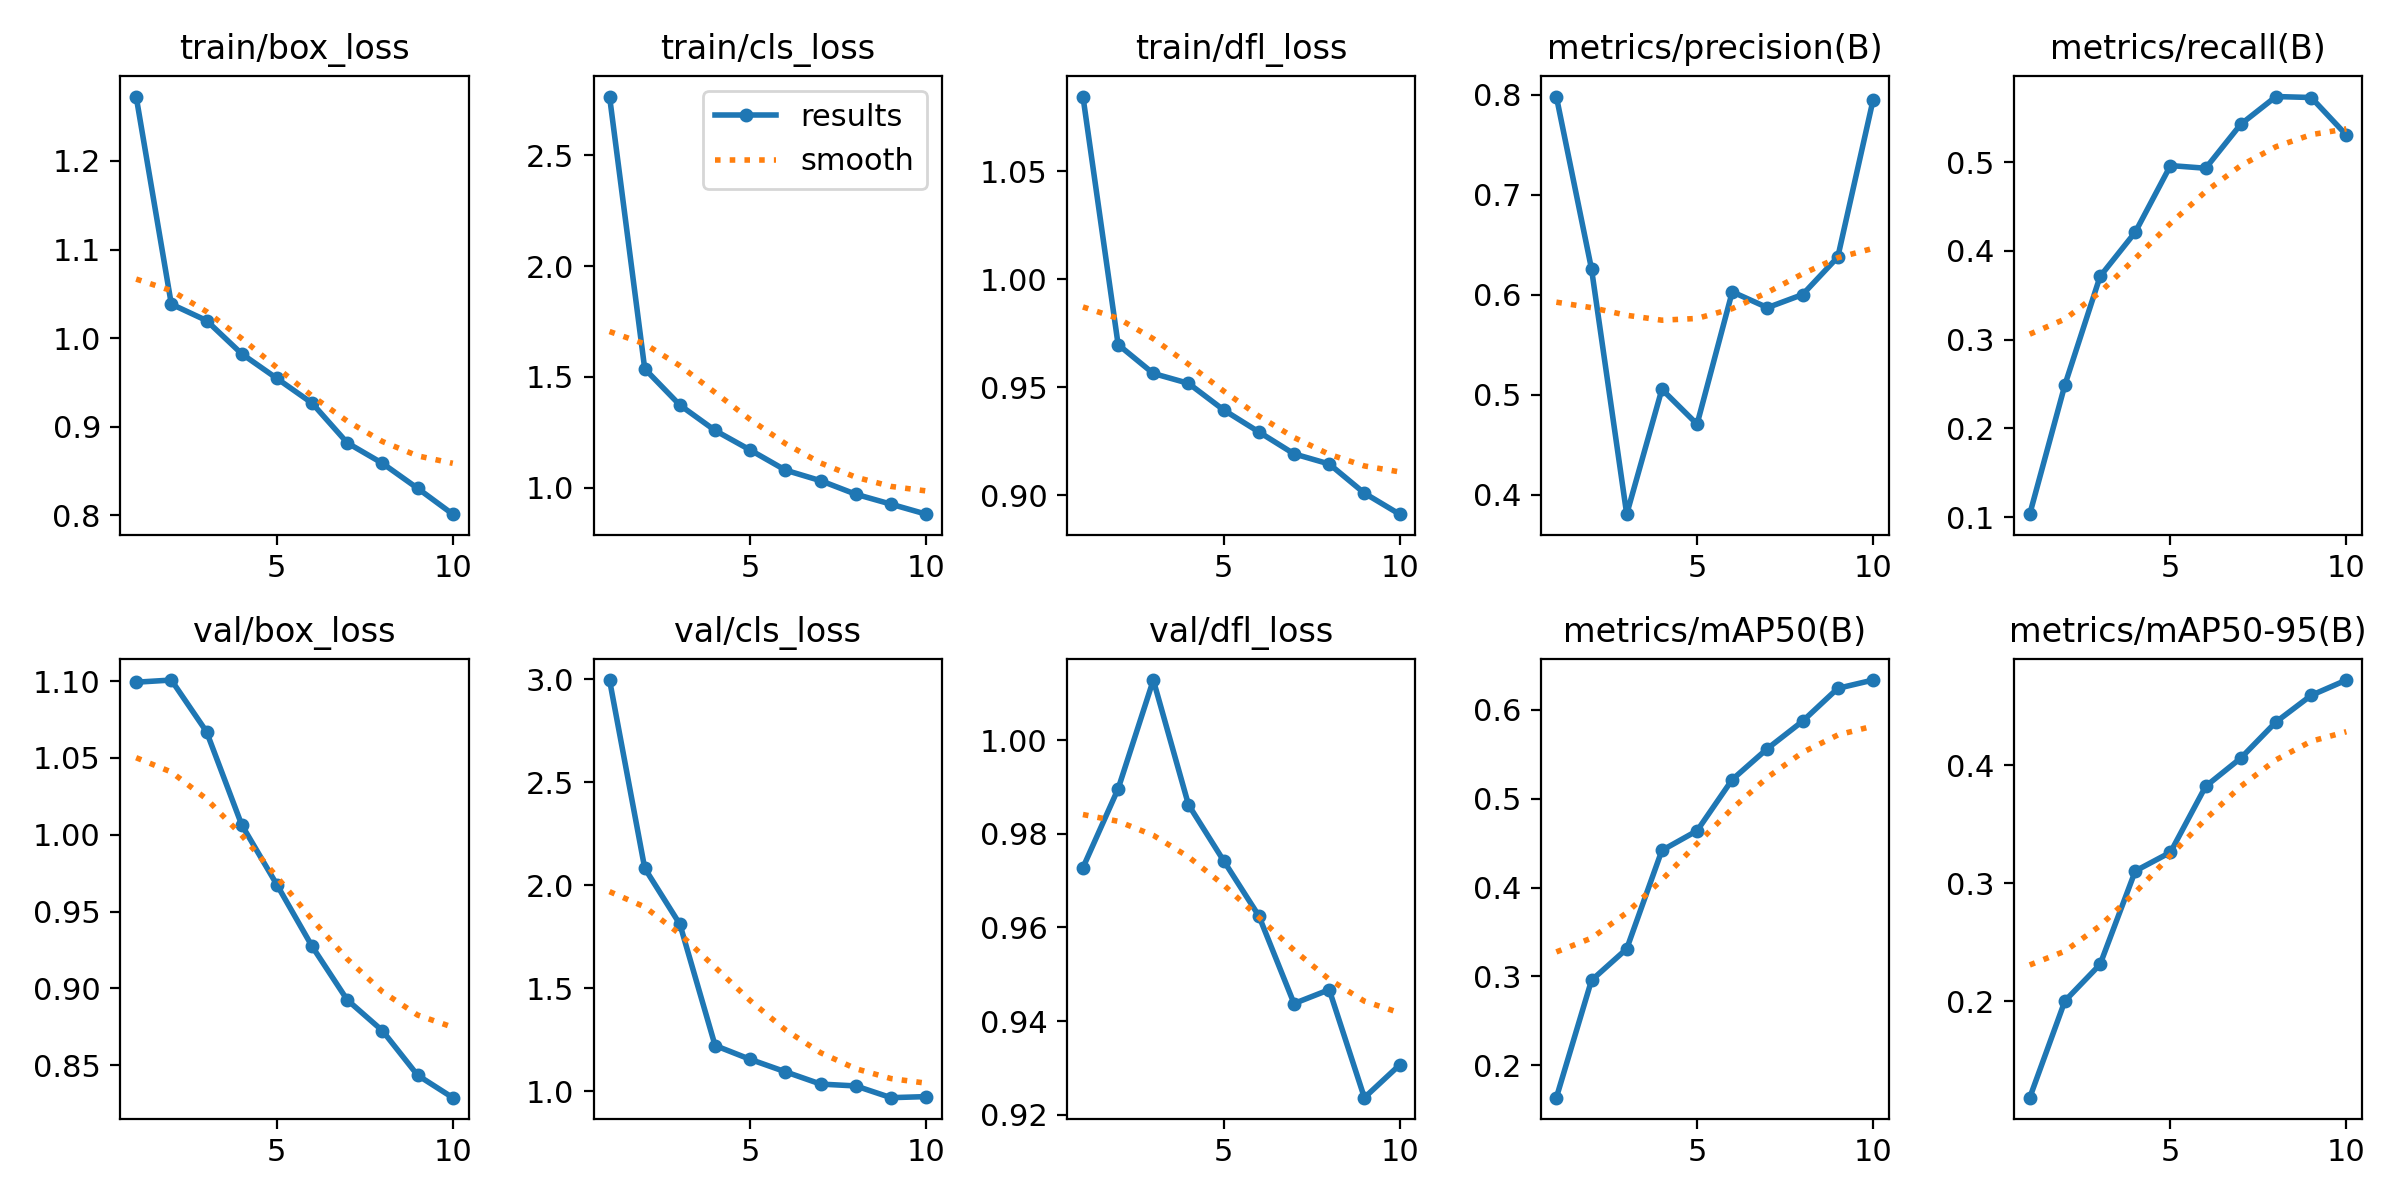


Displaying confusion_matrix.png:


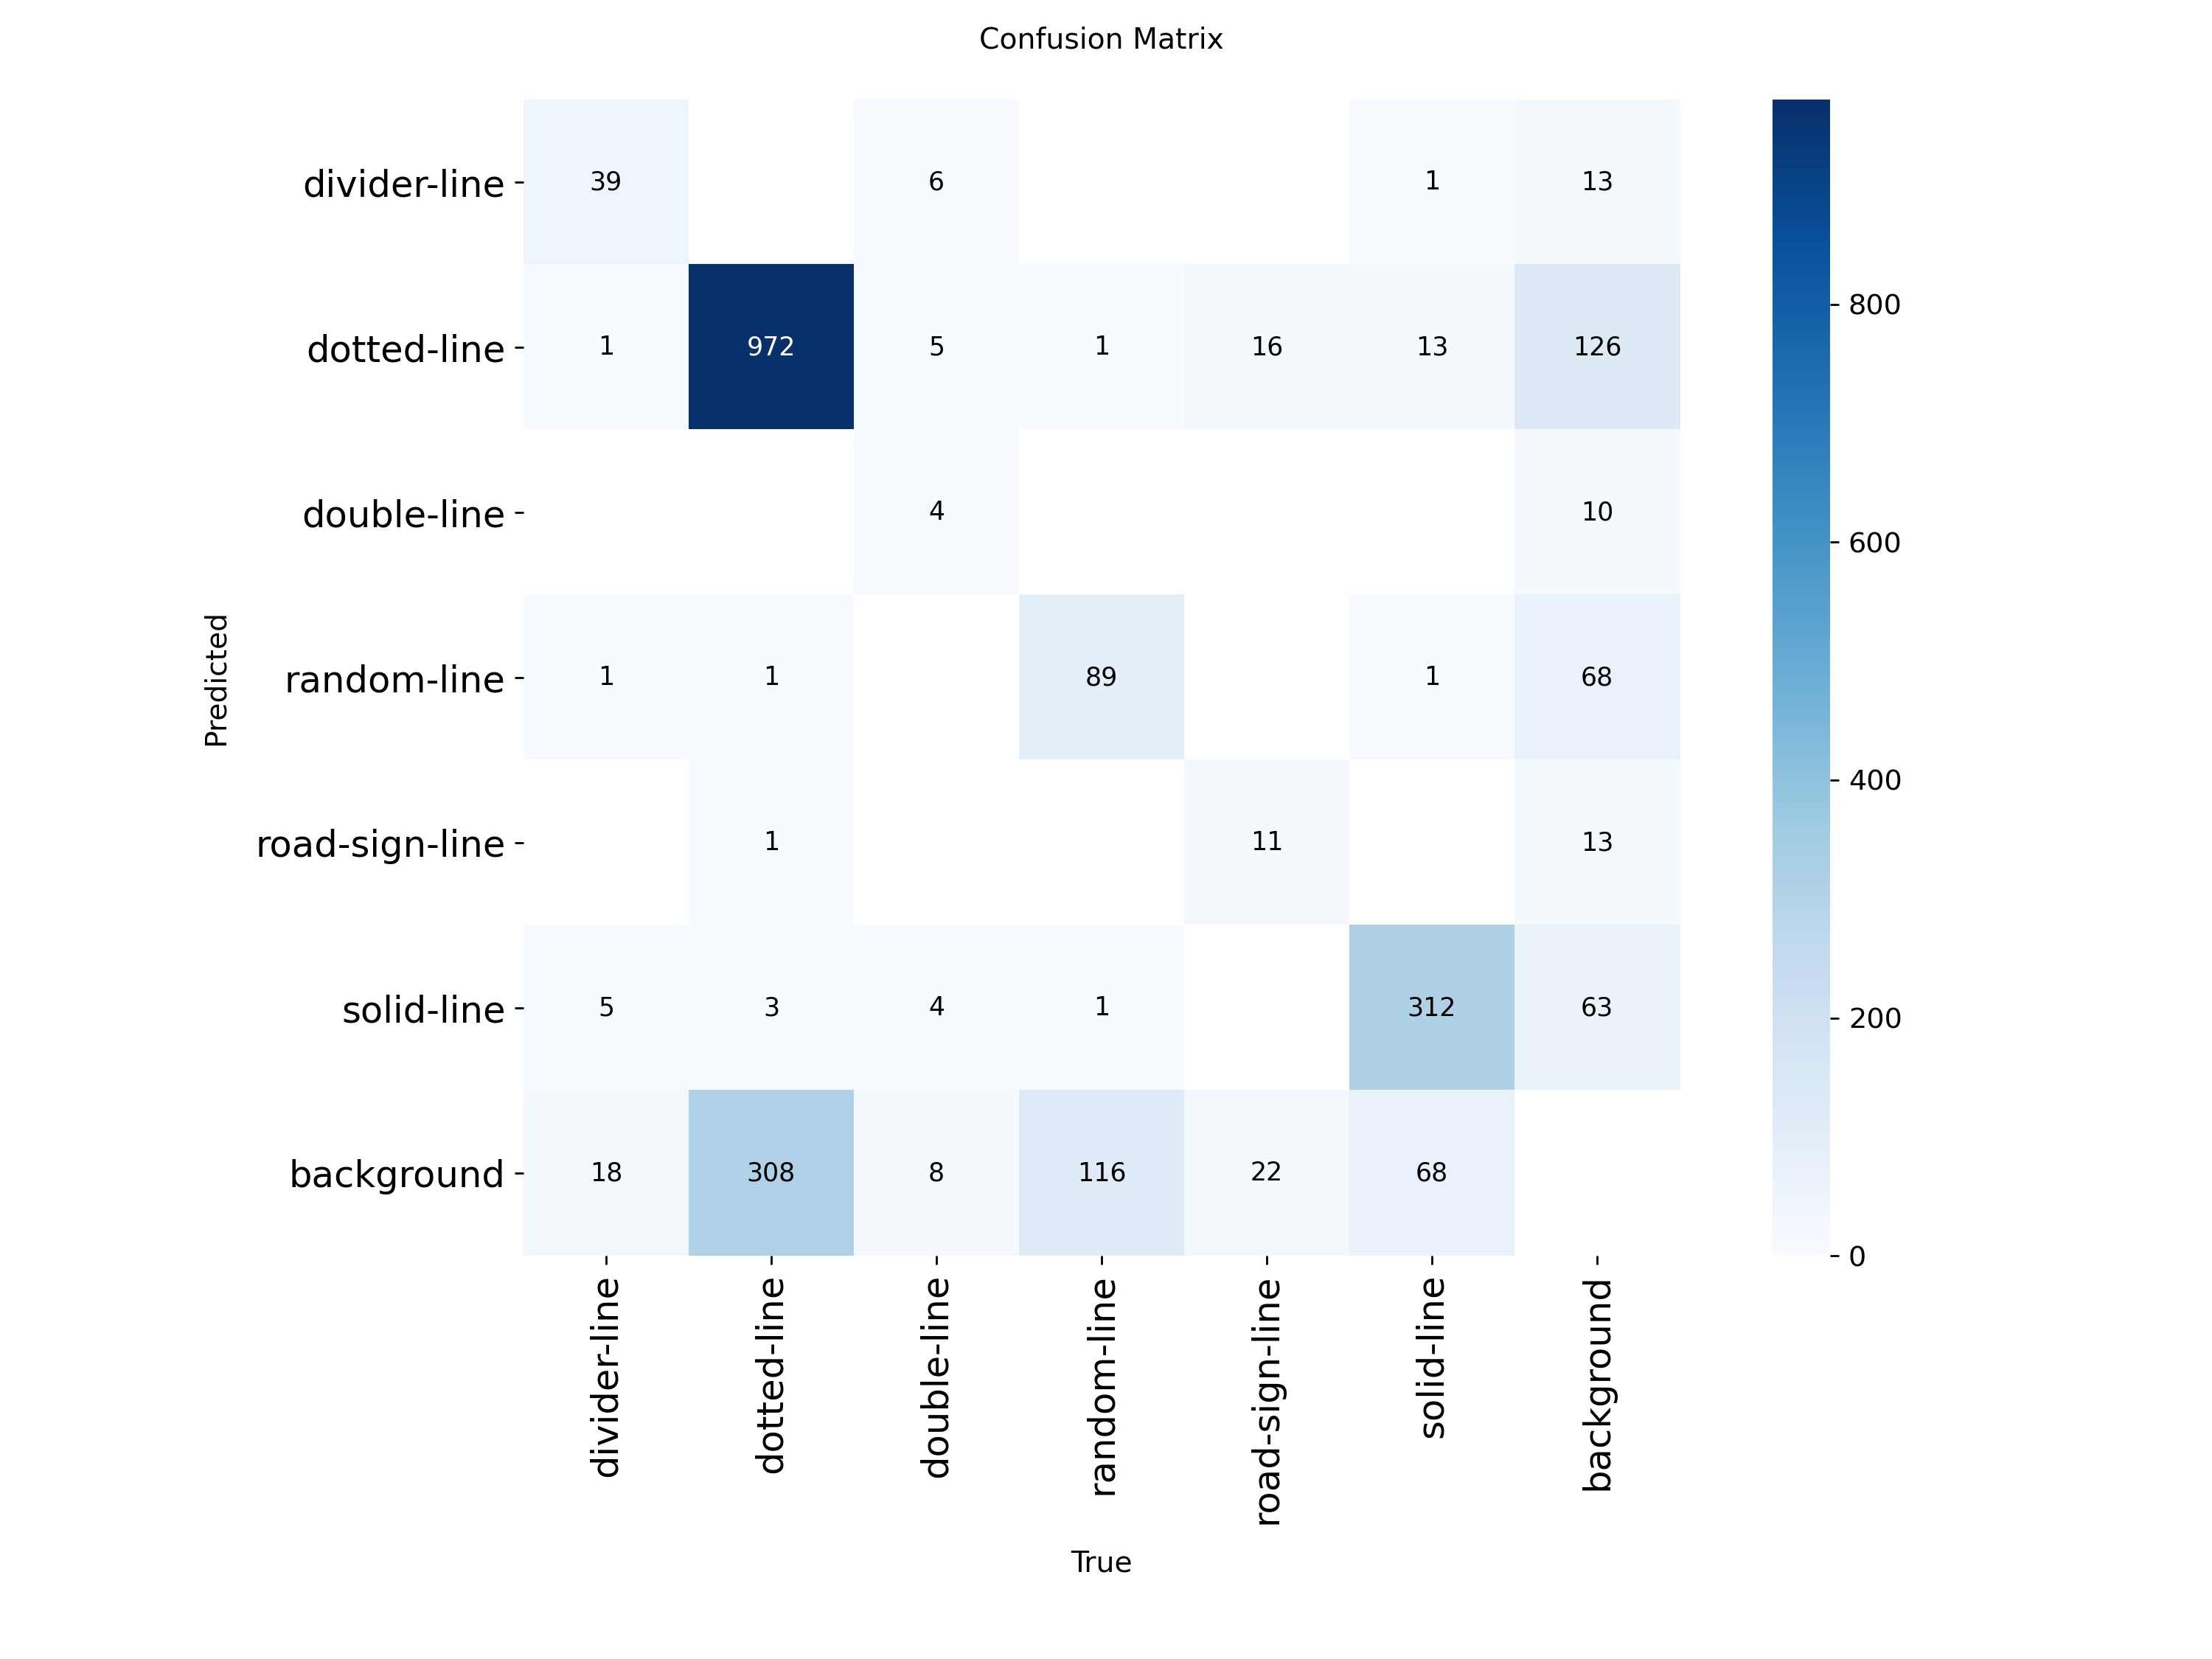

Could not find F1_curve.png (might not be generated yet).
Could not find PR_curve.png (might not be generated yet).


In [ ]:
# Show the metrics
# The path corresponds to the project/name defined in the training function
display_evaluation_metrics('/content/runs/detect/train_road_objects')

In [ ]:
# Run prediction
best_model_path = '/content/runs/detect/train_road_objects/weights/best.pt'
test_folder_path = '/content/drive/MyDrive/data_sandeepa_wrong_overtake/data/test/images/'

Predicting on: /content/drive/MyDrive/data_sandeepa_wrong_overtake/data/test/images/20230619181108_247517_TS_1020_jpg.rf.c72a8c23c7196e2c3280361fa9d09c40.jpg

image 1/1 /content/drive/MyDrive/data_sandeepa_wrong_overtake/data/test/images/20230619181108_247517_TS_1020_jpg.rf.c72a8c23c7196e2c3280361fa9d09c40.jpg: 640x640 9 random-lines, 1 solid-line, 10.7ms
Speed: 2.4ms preprocess, 10.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


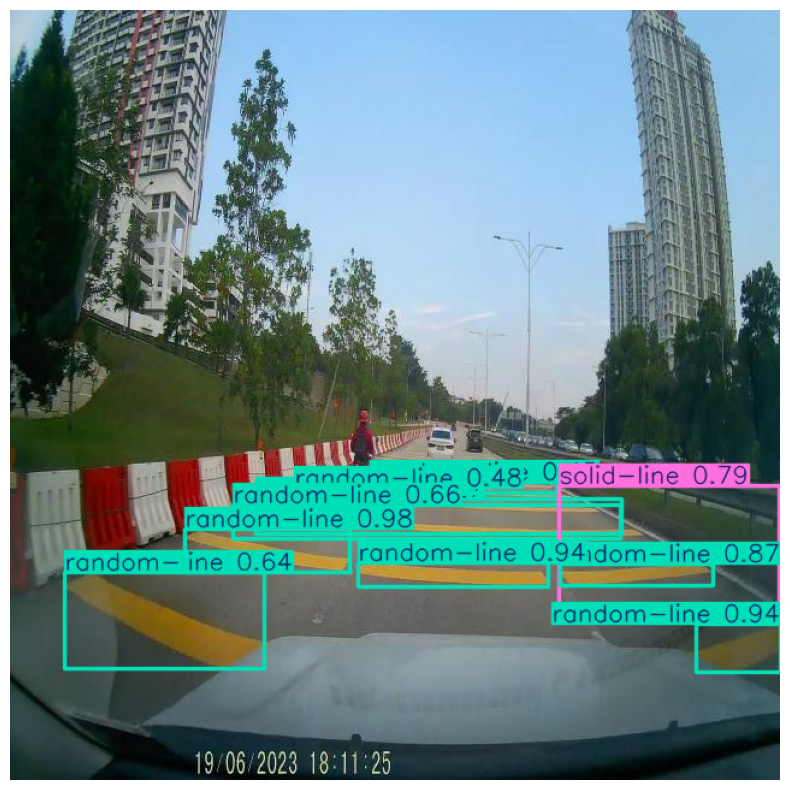

In [ ]:
load_and_predict(best_model_path, test_folder_path)

In [ ]:
# This matches the project/name you defined in your train_yolo_model function
RUN_PATH = '/content/runs/detect/train_road_objects'

# This saves it to the same main folder where your data is
DRIVE_DESTINATION = '/content/drive/MyDrive/data_sandeepa_wrong_overtake/saved_models'

save_model_to_drive(RUN_PATH, DRIVE_DESTINATION, new_name='road_line_detector_v1.pt')

✅ Success! Model saved to Google Drive at:
/content/drive/MyDrive/data_sandeepa_wrong_overtake/saved_models/road_line_detector_v1.pt
